# German Energy Price Forecasting – Exploratory Data Analysis

---

## Introduction

Exploratory Data Analysis (EDA) of German day-ahead electricity prices and actual generation (SMARD.de). Goals:
- Understand structure, quality, and temporal patterns
- Quantify seasonality, daily/weekly cycles, and cross-border price influence
- Engineer first-pass time series & lag features for modeling in Week 2

---

## Table of Contents


0. [Introduction](#introduction)
1. [Import Libraries](#1.-import-libraries)
2. [Data Loading](#2.-data-loading)
3. [Initial Data Inspection](#3.-initial-data-inspection)
4. [Data Cleaning](#4.-data-cleaning)
5. [Feature Engineering](#5-feature-engineering)
6. [Univariate Analysis](#6.-univariate-analysis)
7. [Bivariate/Multivariate Analysis](#7-bivariatemultivariate-analysis)
8. [Insights and Observations](#8-insights-and-observations)
9. [Next Steps / Conclusion](#9-next-steps--conclusion)

## 1. Import Libraries

In [221]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Date Handling
import holidays

# Time Series Analysis
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

### Persistance and Metadata Helpers
import json
from pathlib import Path

### Persistance and Metadata Helpers

In [222]:
RAW_GEN_PATH = "../data/raw/Actual_generation_202101010000_202509180000_Hour.csv"
RAW_PRICE_PATH = "../data/raw/Day-ahead_prices_202101010000_202509180000_Hour.csv"

INTERIM_DIR = Path("../data/interim")
PROCESSED_DIR = Path("../data/processed")
INTERIM_DIR.mkdir(exist_ok=True, parents=True)
PROCESSED_DIR.mkdir(exist_ok=True, parents=True)

def save_parquet(df: pd.DataFrame, path: Path):
    df.to_parquet(path, index=True)

def write_metadata(df: pd.DataFrame, base_path: Path, extra: dict):
    meta = {
        "rows": len(df),
        "columns": df.columns.tolist(),
        "dtypes": {c: str(t) for c, t in df.dtypes.items()},
        "created_utc": pd.Timestamp.utcnow().isoformat(),
        "source_raw_files": [RAW_GEN_PATH, RAW_PRICE_PATH]
    }
    meta.update(extra)
    with open(base_path.with_suffix(".metadata.json"), "w", encoding="utf-8") as f:
        json.dump(meta, f, indent=2)

## 2. Data Loading

In [223]:
# Load the raw datasets for actual generation and day-ahead prices
df_path_gen = '../data/raw/Actual_generation_202101010000_202509180000_Hour.csv'
df_path_price = '../data/raw/Day-ahead_prices_202101010000_202509180000_Hour.csv'

actual_generation = pd.read_csv(
    df_path_gen, 
    sep=';', 
    low_memory=False,
    na_values=['-']
)
day_ahead_prices = pd.read_csv(
    df_path_price, 
    sep=';', 
    low_memory=False,
    na_values=['-']
)

## 3. Initial Data Inspection

In [224]:
# Display the shape and info of the actual generation dataset
print(actual_generation.shape)
actual_generation.info()
actual_generation.head()

(41303, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41303 entries, 0 to 41302
Data columns (total 14 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Start date                                         41303 non-null  object 
 1   End date                                           41303 non-null  object 
 2   Biomass [MWh] Calculated resolutions               41300 non-null  object 
 3   Hydropower [MWh] Calculated resolutions            41300 non-null  object 
 4   Wind offshore [MWh] Calculated resolutions         41300 non-null  object 
 5   Wind onshore [MWh] Calculated resolutions          41300 non-null  object 
 6   Photovoltaics [MWh] Calculated resolutions         41300 non-null  object 
 7   Other renewable [MWh] Calculated resolutions       41300 non-null  float64
 8   Nuclear [MWh] Calculated resolutions               26988 non-null  object 

,Start date,End date,Biomass [MWh] Calculated resolutions,Hydropower [MWh] Calculated resolutions,Wind offshore [MWh] Calculated resolutions,Wind onshore [MWh] Calculated resolutions,Photovoltaics [MWh] Calculated resolutions,Other renewable [MWh] Calculated resolutions,Nuclear [MWh] Calculated resolutions,Lignite [MWh] Calculated resolutions,Hard coal [MWh] Calculated resolutions,Fossil gas [MWh] Calculated resolutions,Hydro pumped storage [MWh] Calculated resolutions,Other conventional [MWh] Calculated resolutions
0,"Jan 1, 2021 12:00 AM","Jan 1, 2021 1:00 AM","4,481.00","1,203.00",383.00,"3,928.25",1.00,213.00,"8,144.75","11,608.50","3,443.75","6,923.00",347.25,"1,637.50"
1,"Jan 1, 2021 1:00 AM","Jan 1, 2021 2:00 AM","4,453.00","1,192.75",394.50,"3,528.25",1.00,213.25,"8,150.25","11,602.75","3,044.75","6,688.00",518.50,"1,636.00"
2,"Jan 1, 2021 2:00 AM","Jan 1, 2021 3:00 AM","4,440.50","1,161.00",305.25,"3,198.00",1.00,216.50,"8,156.50","11,758.50","3,067.25","6,586.00",170.00,"1,630.00"
3,"Jan 1, 2021 3:00 AM","Jan 1, 2021 4:00 AM","4,424.75","1,177.75",319.25,"2,768.75",1.00,218.00,"8,153.75","12,337.50","2,852.50","6,396.50",2.00,"1,621.50"
4,"Jan 1, 2021 4:00 AM","Jan 1, 2021 5:00 AM","4,430.75","1,153.25",296.25,"2,462.25",1.00,221.50,"8,150.50","12,395.00","2,713.25","6,333.00",6.00,"1,621.50"


In [225]:
# Data Inspection (continued)
# Display the shape and info of the day-ahead prices dataset
print(day_ahead_prices.shape)
day_ahead_prices.info()
day_ahead_prices.head()

(41303, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41303 entries, 0 to 41302
Data columns (total 19 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Start date                                       41303 non-null  object 
 1   End date                                         41303 non-null  object 
 2   Germany/Luxembourg [€/MWh] Original resolutions  41303 non-null  float64
 3   ∅ DE/LU neighbours [€/MWh] Original resolutions  41207 non-null  float64
 4   Belgium [€/MWh] Original resolutions             41303 non-null  float64
 5   Denmark 1 [€/MWh] Original resolutions           41303 non-null  float64
 6   Denmark 2 [€/MWh] Original resolutions           41303 non-null  float64
 7   France [€/MWh] Original resolutions              41303 non-null  object 
 8   Netherlands [€/MWh] Original resolutions         41303 non-null  float64
 9   Norway 2 [€/MWh]

,Start date,End date,Germany/Luxembourg [€/MWh] Original resolutions,∅ DE/LU neighbours [€/MWh] Original resolutions,Belgium [€/MWh] Original resolutions,Denmark 1 [€/MWh] Original resolutions,Denmark 2 [€/MWh] Original resolutions,France [€/MWh] Original resolutions,Netherlands [€/MWh] Original resolutions,Norway 2 [€/MWh] Original resolutions,Austria [€/MWh] Original resolutions,Poland [€/MWh] Original resolutions,Sweden 4 [€/MWh] Original resolutions,Switzerland [€/MWh] Original resolutions,Czech Republic [€/MWh] Original resolutions,DE/AT/LU [€/MWh] Original resolutions,Northern Italy [€/MWh] Calculated resolutions,Slovenia [€/MWh] Original resolutions,Hungary [€/MWh] Original resolutions
0,"Jan 1, 2021 12:00 AM","Jan 1, 2021 1:00 AM",50.87,44.17,50.87,50.87,50.87,50.87,50.87,24.95,50.87,34.18,24.95,50.98,45.54,NaN,50.87,50.87,45.54
1,"Jan 1, 2021 1:00 AM","Jan 1, 2021 2:00 AM",48.19,41.63,48.19,48.19,48.19,48.19,48.19,24.35,48.19,32.61,24.35,45.94,41.59,NaN,48.19,48.19,41.59
2,"Jan 1, 2021 2:00 AM","Jan 1, 2021 3:00 AM",44.68,39.38,44.68,44.68,44.68,44.68,44.68,23.98,44.68,32.58,23.98,44.53,40.05,NaN,44.68,44.68,40.05
3,"Jan 1, 2021 3:00 AM","Jan 1, 2021 4:00 AM",42.92,37.73,42.92,42.92,42.92,42.92,42.92,23.72,42.92,32.20,23.72,41.01,36.90,NaN,42.92,42.92,36.90
4,"Jan 1, 2021 4:00 AM","Jan 1, 2021 5:00 AM",40.39,35.70,40.39,40.39,40.39,40.39,40.39,23.73,40.39,29.16,23.73,39.23,34.47,NaN,40.39,40.39,34.47


In [226]:
# Looking for missing values
print("Missing values in each dataset:")
print("Actual Generation:")
print(actual_generation.isnull().sum())
print("Day Ahead Prices:")
print(day_ahead_prices.isnull().sum())

Missing values in each dataset:
Actual Generation:
Start date                                               0
End date                                                 0
Biomass [MWh] Calculated resolutions                     3
Hydropower [MWh] Calculated resolutions                  3
Wind offshore [MWh] Calculated resolutions               3
Wind onshore [MWh] Calculated resolutions                3
Photovoltaics [MWh] Calculated resolutions               3
Other renewable [MWh] Calculated resolutions             3
Nuclear [MWh] Calculated resolutions                 14315
Lignite [MWh] Calculated resolutions                    28
Hard coal [MWh] Calculated resolutions                  28
Fossil gas [MWh] Calculated resolutions                  3
Hydro pumped storage [MWh] Calculated resolutions        3
Other conventional [MWh] Calculated resolutions         28
dtype: int64
Day Ahead Prices:
Start date                                             0
End date                           

### Initial Data Summary

- Both datasets initially contain 41,303 hourly rows (2021-01-01 to 2025-09-16 23:00). Final range trimmed to exclude an incomplete final day.
- Several generation columns contain missing values (notably Nuclear post-April 2023 due to phase-out). These are treated as zeros (assumed no generation reported).
- One main German price column: "Germany/Luxembourg [€/MWh]" (some other cross-border columns fully empty → dropped).
- Numeric values are delivered as strings (commas + '-' placeholders) and converted to floats.
- Time columns ('Start date', 'End date') parsed to datetime and indexed by 'Start date'.

Next: Clean types, handle missingness, and prepare for merging.

## 4. Data Cleaning

### Data Cleaning Summary

- Dropped Duplicates if any existed
- All date columns are converted to datetime objects for easier time-based analysis.
- Numeric columns with commas and '-' placeholders are cleaned and converted to floats; missing values are handled appropriately.
- For `actual_generation`, missing values are filled with 0, assuming missing means no generation for that period.
- For `day_ahead_prices`, missing values are interpolated to maintain continuity in the time series, and empty columns are dropped.

**Observation:**

- The datasets required significant cleaning to ensure consistency and usability for time series analysis. Handling missing values and proper type conversion are crucial for downstream analysis.


In [227]:
# Remove duplicates if any (safety)
actual_generation = actual_generation.drop_duplicates()
day_ahead_prices = day_ahead_prices.drop_duplicates()

# Convert 'Start date' and 'End date' columns to datetime objects for both datasets
date_format = "%b %d, %Y %I:%M %p"

actual_generation['Start date'] = pd.to_datetime(actual_generation['Start date'], format=date_format)
actual_generation['End date'] = pd.to_datetime(actual_generation['End date'], format=date_format)
day_ahead_prices['Start date'] = pd.to_datetime(day_ahead_prices['Start date'], format=date_format)
day_ahead_prices['End date'] = pd.to_datetime(day_ahead_prices['End date'], format=date_format)

# Trim incomplete trailing day to avoid partial lag artifacts later
actual_generation = actual_generation[actual_generation['Start date'] < '2025-09-17']
day_ahead_prices = day_ahead_prices[day_ahead_prices['Start date'] < '2025-09-17']

# Set 'Start date' as time index for time-series alignment
actual_generation.set_index('Start date', inplace=True)
day_ahead_prices.set_index('Start date', inplace=True)

In [228]:
# Convert all object columns to float after removing commas
for df in [actual_generation, day_ahead_prices]:
    for col in df.select_dtypes(include=['object']).columns:
        # Remove commas and convert to float
        df[col] = df[col].str.replace(',', '').astype(float)

In [229]:
# Handle missing values in both datasets
# For actual_generation: replace all missing values with 0 (assume no generation)
actual_generation.fillna(0, inplace=True)

# For day_ahead_prices: interpolate missing values, and drop empty columns
day_ahead_prices.dropna(axis=1, how='all', inplace=True)
day_ahead_prices.interpolate(method='linear', inplace=True)

# Sanity check for missing values
print('Any missing values in actual_generation?', actual_generation.isnull().values.any())
print('Any missing values in day_ahead_prices?', day_ahead_prices.isnull().values.any())

Any missing values in actual_generation? False
Any missing values in day_ahead_prices? False


### Save Clean (Canonical) Datasets

In [230]:
# --- Save Clean / Canonical Layer ---

# Convert categorical columns to string before saving
for df in [actual_generation, day_ahead_prices]:
    # Convert categorical columns to string
    for col in df.select_dtypes(include=['category']).columns:
        df[col] = df[col].astype(str)
    # Convert object columns to string (final safeguard)
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str)

save_parquet(actual_generation, INTERIM_DIR / "actual_generation_clean.parquet")
save_parquet(day_ahead_prices, INTERIM_DIR / "day_ahead_prices_clean.parquet")

write_metadata(actual_generation, INTERIM_DIR / "actual_generation_clean",
               {"layer": "interim", "description": "Cleaned actual generation (hourly) post-trim."})

write_metadata(day_ahead_prices, INTERIM_DIR / "day_ahead_prices_clean",
               {"layer": "interim", "description": "Cleaned day-ahead prices (hourly) post-trim."})

print("Saved interim clean datasets.")

Saved interim clean datasets.


## 5. Feature Engineering

### Helper Functions (Feature Extraction Support)

In [231]:
# Helper function to assign season based on month
def get_season(month):
    '''Decide which season it is based on month'''
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# List of German public holidays for feature extraction
german_holidays_dates = set(holidays.Germany(years=[2021, 2022, 2023, 2024, 2025]).keys())

# Extract temporal features from 'Start date'
def temporal_features(df):
    """Extract temporal data from the provided time-series Dataframe"""
    df['year'] = df.index.year
    df['season'] = [get_season(m) for m in df.index.month]
    df['season'] = df['season'].astype('category')
    df['month'] = df.index.month.astype('category')
    df['day_of_week'] = df.index.day_name().astype('category')
    df['hour'] = df.index.hour.astype('category')
    df['public_holiday'] = df.index.date
    df['public_holiday'] = df["public_holiday"].isin(german_holidays_dates).astype('category')
    return df

# Function to clean column names
def clean_column_names(df):
    """Clean up long SMARD.de column names for better readability"""
    df_clean = df.copy()
    
    # Create a mapping dictionary for common replacements
    replacements = {
        'Calculated resolutions': '',
        'Original resolutions': ''
    }
    
    # Apply replacements
    new_columns = []
    for col in df_clean.columns:
        new_col = col
        for old, new in replacements.items():
            new_col = new_col.replace(old, new)
        new_columns.append(new_col.strip())
    
    df_clean.columns = new_columns
    return df_clean

def categorize_columns(df):
    """Organize columns by type for better analysis"""
    
    # Price columns (neighboring countries)
    price_cols = [col for col in df.columns if any(country in col for country in 
                 ['DE', 'Germany', 'Austria', 'Belgium', 'Denmark', 'France', 'Netherlands', 'Poland', 'Czech']) and '€' in col]
    
    # Renewable generation
    renewable_cols = [col for col in df.columns if any(source in col.lower() for source in 
                     ['wind', 'solar', 'photovoltaic', 'hydro', 'biomass', 'renewable'])]
    
    # Conventional generation  
    conventional_cols = [col for col in df.columns if any(source in col.lower() for source in 
                        ['nuclear', 'lignite', 'coal', 'gas', 'conventional'])]
    
    # Target and features
    target_col = 'Germany/Luxembourg [€/MWh]'
    temporal_cols = ['year', 'month', 'season', 'day_of_week', 'hour', 'public_holiday']
    
    return (
        target_col,
        price_cols,
        renewable_cols,
        conventional_cols,
        temporal_cols
    )

def cyclic_encode(df, col, max_val):
    """Cyclic encoding for periodic features"""
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    df.drop(columns=[col], inplace=True)
    return df

### Merging Both Datasets

In [232]:
gen_and_prices_df = pd.merge(actual_generation,
                             day_ahead_prices,
                             left_index=True,
                             right_index=True).drop(columns=["End date_x", "End date_y"])
gen_and_prices_df = clean_column_names(gen_and_prices_df)
gen_and_prices_df

,Biomass [MWh],Hydropower [MWh],Wind offshore [MWh],Wind onshore [MWh],Photovoltaics [MWh],Other renewable [MWh],Nuclear [MWh],Lignite [MWh],Hard coal [MWh],Fossil gas [MWh],...,Netherlands [€/MWh],Norway 2 [€/MWh],Austria [€/MWh],Poland [€/MWh],Sweden 4 [€/MWh],Switzerland [€/MWh],Czech Republic [€/MWh],Northern Italy [€/MWh],Slovenia [€/MWh],Hungary [€/MWh]
Start date,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,4481.00,1203.00,383.00,3928.25,1.00,213.00,8144.75,11608.50,3443.75,6923.00,...,50.87,24.95,50.87,34.18,24.95,50.98,45.54,50.87,50.87,45.54
2021-01-01 01:00:00,4453.00,1192.75,394.50,3528.25,1.00,213.25,8150.25,11602.75,3044.75,6688.00,...,48.19,24.35,48.19,32.61,24.35,45.94,41.59,48.19,48.19,41.59
2021-01-01 02:00:00,4440.50,1161.00,305.25,3198.00,1.00,216.50,8156.50,11758.50,3067.25,6586.00,...,44.68,23.98,44.68,32.58,23.98,44.53,40.05,44.68,44.68,40.05
2021-01-01 03:00:00,4424.75,1177.75,319.25,2768.75,1.00,218.00,8153.75,12337.50,2852.50,6396.50,...,42.92,23.72,42.92,32.20,23.72,41.01,36.90,42.92,42.92,36.90
2021-01-01 04:00:00,4430.75,1153.25,296.25,2462.25,1.00,221.50,8150.50,12395.00,2713.25,6333.00,...,40.39,23.73,40.39,29.16,23.73,39.23,34.47,40.39,40.39,34.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-16 19:00:00,3733.00,1763.50,6381.75,29942.25,192.75,93.00,0.00,5034.25,1536.75,3816.00,...,121.21,0.69,135.00,155.52,86.05,107.40,149.05,135.00,185.47,364.19
2025-09-16 20:00:00,3729.00,1744.25,6260.50,29404.50,0.00,93.00,0.00,0.00,0.00,3705.50,...,120.79,0.69,120.46,115.67,64.85,107.39,111.00,126.81,134.51,179.00
2025-09-16 21:00:00,3714.75,1684.25,5853.00,29371.00,0.00,93.00,0.00,0.00,0.00,3221.75,...,98.78,0.69,102.45,90.64,41.65,102.45,98.67,115.00,115.00,153.00


#### Merged Dataset Feature Engineering

In [233]:
# Categorize columns
target_col, price_cols, renewable_cols, conventional_cols, temporal_cols = categorize_columns(gen_and_prices_df)

# Extract temporal features
gen_and_prices_df = temporal_features(gen_and_prices_df)

# Create new features

# Total energy generation
gen_and_prices_df['Total Generation [MWh]'] = gen_and_prices_df[renewable_cols + conventional_cols].sum(axis=1, skipna=True)

# Previous day total generation
gen_and_prices_df['Total Generation Previous Day [MWh]'] = gen_and_prices_df['Total Generation [MWh]'].shift(24)

# Renewable generation
gen_and_prices_df['Total Renewable [MWh]'] = gen_and_prices_df[renewable_cols].sum(axis=1, skipna=True)

# Non-renewable generation
gen_and_prices_df['Total Non-Renewable [MWh]'] = gen_and_prices_df[conventional_cols].sum(axis=1, skipna=True)

# Renewable ratio
gen_and_prices_df['Renewable Ratio'] = gen_and_prices_df['Total Renewable [MWh]'] / gen_and_prices_df['Total Generation [MWh]']
gen_and_prices_df["Renewable Ratio"] = gen_and_prices_df["Renewable Ratio"].fillna(0) # If total generation is 0, set ratio to 0

# Previous day renewable ratio
gen_and_prices_df['Renewable Ratio Previous Day'] = gen_and_prices_df['Renewable Ratio'].shift(24)

# Renewable ratio interaction with hour of day
gen_and_prices_df['Hour-Renewable Interaction'] = gen_and_prices_df['hour'].astype(int) * gen_and_prices_df['Renewable Ratio Previous Day']

# Renewable ratio delta (change from previous day)
gen_and_prices_df['Renewable Ratio Delta'] = gen_and_prices_df['Renewable Ratio Previous Day'] - gen_and_prices_df['Renewable Ratio'].shift(48)

# Previous 3-day moving average for Renewable Ratio
gen_and_prices_df['Renewable Ratio 3-Day MA'] = gen_and_prices_df['Renewable Ratio Previous Day'].rolling(window=72, min_periods=1).mean()

# Previous year same hour renewable ratio
gen_and_prices_df['Renewable Ratio Last Year'] = gen_and_prices_df['Renewable Ratio'].shift(24*365)

# Fill NaN values in the yearly feature with the mean of the Renewable Ratio
gen_and_prices_df['Renewable Ratio Last Year'] = gen_and_prices_df['Renewable Ratio Last Year'].fillna(gen_and_prices_df['Renewable Ratio'].mean())


# Adding lagged features for prices of neighboring countries and target variable
previous_day_price_cols = []
previous_day_STD_price_cols = []
previous_3_day_MA_price_cols = []
previous_week_price_cols = []

for col in price_cols:
    gen_and_prices_df[f"{col} Previous Day"] = gen_and_prices_df[col].shift(24)
    previous_day_price_cols.append(f"{col} Previous Day")

    # Previous 3-day Rolling moving average for neighboring countries' prices
    gen_and_prices_df[f"{col} 3-Day MA"] = gen_and_prices_df[f"{col} Previous Day"].rolling(window=72, min_periods=1).mean()
    previous_3_day_MA_price_cols.append(f"{col} 3-Day MA")

    # Previous Day's 24-hour rolling standard deviation for neighboring countries' prices
    gen_and_prices_df[f"{col} Previous Day 24-Hour Std"] = gen_and_prices_df[f"{col} Previous Day"].rolling(window=24, min_periods=1).std()
    previous_day_STD_price_cols.append(f"{col} Previous Day 24-Hour Std")

    # Previous week same hour prices for neighboring countries
    gen_and_prices_df[f"{col} Last Week"] = gen_and_prices_df[col].shift(24*7)
    previous_week_price_cols.append(f"{col} Last Week")

previous_day_neighboring_price_cols = [col for col in previous_day_price_cols if col != target_col]

# Previous day STD for neighboring countries' prices per row
gen_and_prices_df['Neighboring Countries Previous Day Std'] = gen_and_prices_df[previous_day_neighboring_price_cols].std(axis=1, skipna=True)

# Previous day spread (max-min) for neighboring countries' prices per row
gen_and_prices_df['Neighboring Countries Previous Day Spread'] = gen_and_prices_df[previous_day_neighboring_price_cols].max(axis=1, skipna=True) - gen_and_prices_df[previous_day_neighboring_price_cols].min(axis=1, skipna=True)

# Drop rows introduced by lag/rolling/window creation (ensures pure past dependency)
gen_and_prices_df.dropna(inplace=True)


### Making the final merged dataset with all relevant features for modeling.

In [234]:
model_features = [
    target_col,
    f"{target_col} Previous Day", 
    f"{target_col} Previous Day 24-Hour Std", 
    f"{target_col} 3-Day MA",
    f"{target_col} Last Week",
    *temporal_cols,
    "Renewable Ratio Previous Day", 
    "Renewable Ratio 3-Day MA", 
    "Renewable Ratio Delta",
    "Hour-Renewable Interaction",
    "Neighboring Countries Previous Day Spread", 
    "∅ DE/LU neighbours [€/MWh] Previous Day", 
    "∅ DE/LU neighbours [€/MWh] Previous Day 24-Hour Std", 
    "∅ DE/LU neighbours [€/MWh] 3-Day MA",
    "∅ DE/LU neighbours [€/MWh] Last Week"
]
model_ready_df = gen_and_prices_df[model_features].copy()
model_ready_df.info()
# Change categorical columns to codes for model compatibility
for col in temporal_cols:
    if model_ready_df[col].dtype.name == 'category':
        model_ready_df[col] = model_ready_df[col].cat.codes

# Cyclic encoding for hour of day, day of week, season, and month
model_ready_df = cyclic_encode(model_ready_df, 'hour', 23)
model_ready_df = cyclic_encode(model_ready_df, 'day_of_week', 6)
model_ready_df = cyclic_encode(model_ready_df, 'season', 3)
model_ready_df = cyclic_encode(model_ready_df, 'month', 11)
model_ready_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41119 entries, 2021-01-08 00:00:00 to 2025-09-16 23:00:00
Data columns (total 20 columns):
 #   Column                                               Non-Null Count  Dtype   
---  ------                                               --------------  -----   
 0   Germany/Luxembourg [€/MWh]                           41119 non-null  float64 
 1   Germany/Luxembourg [€/MWh] Previous Day              41119 non-null  float64 
 2   Germany/Luxembourg [€/MWh] Previous Day 24-Hour Std  41119 non-null  float64 
 3   Germany/Luxembourg [€/MWh] 3-Day MA                  41119 non-null  float64 
 4   Germany/Luxembourg [€/MWh] Last Week                 41119 non-null  float64 
 5   year                                                 41119 non-null  int32   
 6   month                                                41119 non-null  category
 7   season                                               41119 non-null  category
 8   day_of_week          

### Saving Datasets

In [235]:
# --- Save Final Feature Set ---

feature_version = "v1"
feature_stamp = pd.Timestamp.utcnow().strftime("%Y%m%d")
features_path = PROCESSED_DIR / f"features_{feature_version}_{feature_stamp}.parquet"

save_parquet(model_ready_df, features_path)

write_metadata(
    model_ready_df,
    features_path.with_suffix(""),
    {
        "layer": "processed",
        "description": "Model-ready feature set with lags, ratios, spreads.",
        "target": target_col,
        "feature_groups": {
            "price_lags": [c for c in model_ready_df.columns if "Previous Day" in c or "Last Week" in c],
            "rolling_stats": [c for c in model_ready_df.columns if "3-Day MA" in c or "24-Hour Std" in c],
            "renewable_features": [c for c in model_ready_df.columns if "Renewable Ratio" in c],
            "temporal": ['year', 'month_sin', 'month_cos', 'season_sin', "season_cos", 'day_of_week_sin', "day_of_week_cos", 'hour_sin', "hour_cos", 'public_holiday'],
            "derived_spreads": [c for c in model_ready_df.columns if "Spread" in c or "Relative Spread" in c]
        }
    }
)

print(f"Saved processed feature dataset to: {features_path}")

Saved processed feature dataset to: ..\data\processed\features_v1_20251009.parquet


In [236]:
# --- Train/Test Split ---
# Adjust cutoff date as needed
train_cutoff = "2024-06-01" # YYYY-MM-DD format at ~70% of data

train_df = model_ready_df[gen_and_prices_df.index < train_cutoff]
test_df = model_ready_df[gen_and_prices_df.index >= train_cutoff]

save_parquet(train_df, PROCESSED_DIR / f"train_{feature_version}_{feature_stamp}.parquet")
save_parquet(test_df, PROCESSED_DIR / f"test_{feature_version}_{feature_stamp}.parquet")

write_metadata(train_df, PROCESSED_DIR / f"train_{feature_version}_{feature_stamp}",
               {"layer": "processed", "split": "train", "range_end": train_cutoff})
write_metadata(test_df, PROCESSED_DIR / f"test_{feature_version}_{feature_stamp}",
               {"layer": "processed", "split": "test", "range_start": train_cutoff})

print("Train/Test splits saved.")

Train/Test splits saved.


## 6. Univariate Analysis


In [237]:
# Display summary statistics for the target variable
gen_and_prices_df["Germany/Luxembourg [€/MWh]"].describe()

count    41119.000000
mean       120.945779
std        103.017860
min       -500.000000
25%         65.490000
50%         96.210000
75%        141.025000
max        936.280000
Name: Germany/Luxembourg [€/MWh], dtype: float64

The minimum price is negative → reflects hours of excess supply (e.g., high renewable output + low demand).

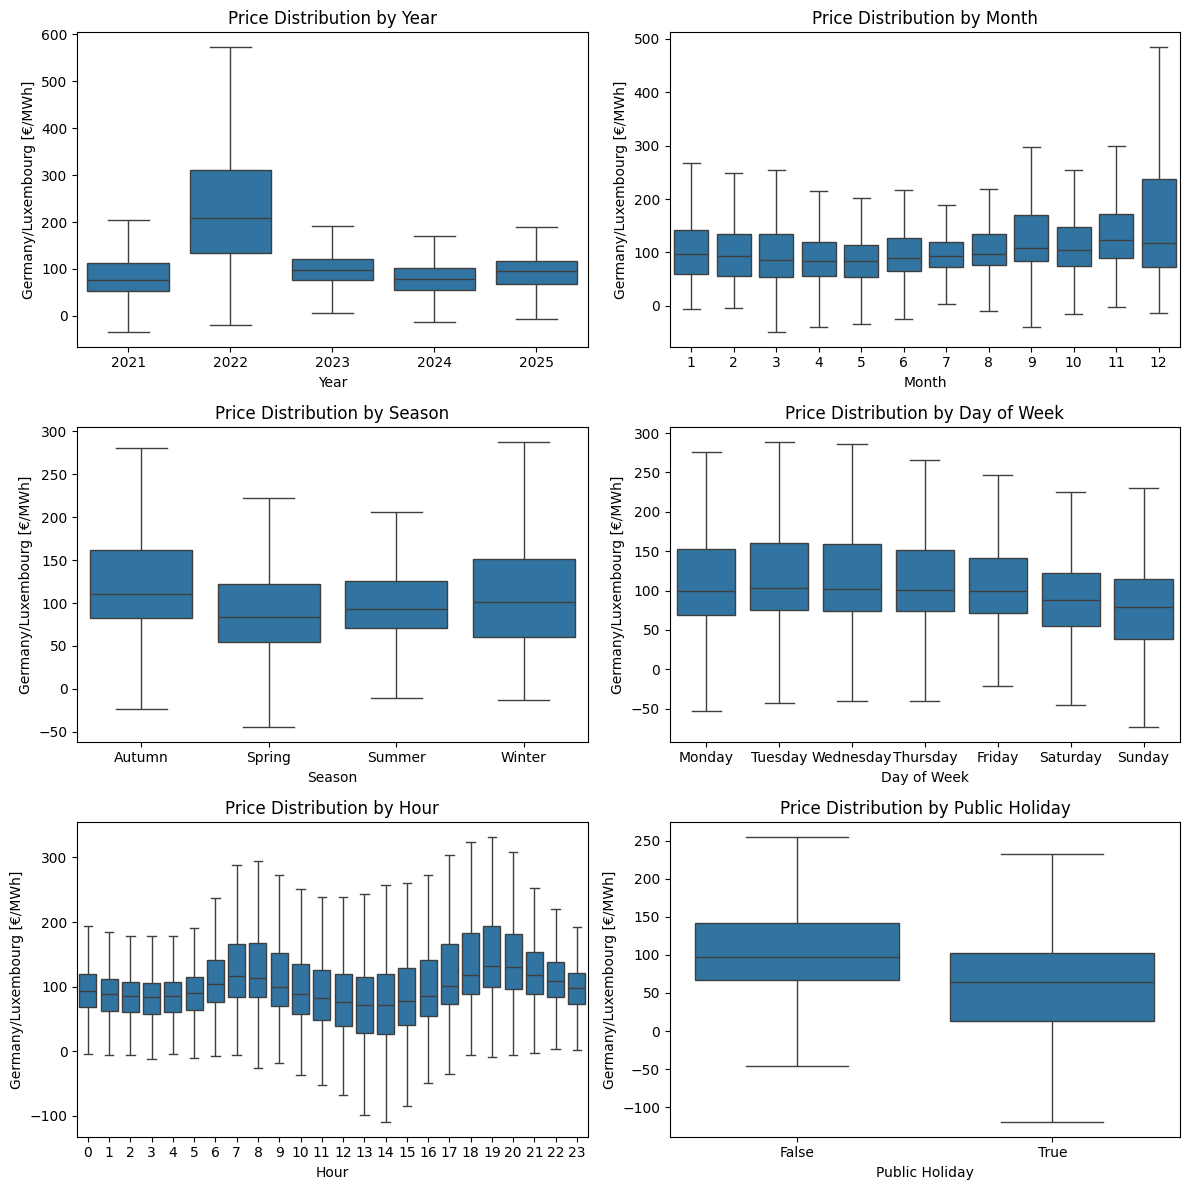

In [238]:
# Box plots to visualize price distribution by year, month, season, and day of the week

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Box plot for price by year
sns.boxplot(
    ax=axes[0, 0], 
    x='year', 
    y='Germany/Luxembourg [€/MWh]', 
    data=gen_and_prices_df,
    showfliers=False
)
axes[0, 0].set_title('Price Distribution by Year')
axes[0, 0].set_xlabel('Year')

# Box plot for price by month
sns.boxplot(
    ax=axes[0, 1], 
    x='month', 
    y='Germany/Luxembourg [€/MWh]', 
    data=gen_and_prices_df, 
    showfliers=False
)
axes[0, 1].set_title('Price Distribution by Month')
axes[0, 1].set_xlabel('Month')

# Box plot for price by season
sns.boxplot(
    ax=axes[1, 0], 
    x='season', 
    y='Germany/Luxembourg [€/MWh]', 
    data=gen_and_prices_df, 
    showfliers=False
)
axes[1, 0].set_title('Price Distribution by Season')
axes[1, 0].set_xlabel('Season')

# Box plot for price by day of the week
sns.boxplot(
    ax=axes[1, 1], 
    x='day_of_week', 
    y='Germany/Luxembourg [€/MWh]', 
    data=gen_and_prices_df, 
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
    showfliers=False
)
axes[1, 1].set_title('Price Distribution by Day of Week')
axes[1, 1].set_xlabel('Day of Week')

# Box plot for price by hour
sns.boxplot(
    ax=axes[2, 0], 
    x='hour', 
    y='Germany/Luxembourg [€/MWh]', 
    data=gen_and_prices_df, 
    showfliers=False
)
axes[2, 0].set_title('Price Distribution by Hour')
axes[2, 0].set_xlabel('Hour')

# Box plot for price by public holiday
sns.boxplot(
    ax=axes[2, 1], 
    x='public_holiday',
    y='Germany/Luxembourg [€/MWh]', 
    data=gen_and_prices_df,
    showfliers=False
)
axes[2, 1].set_title('Price Distribution by Public Holiday')
axes[2, 1].set_xlabel('Public Holiday')

plt.tight_layout()
plt.show()

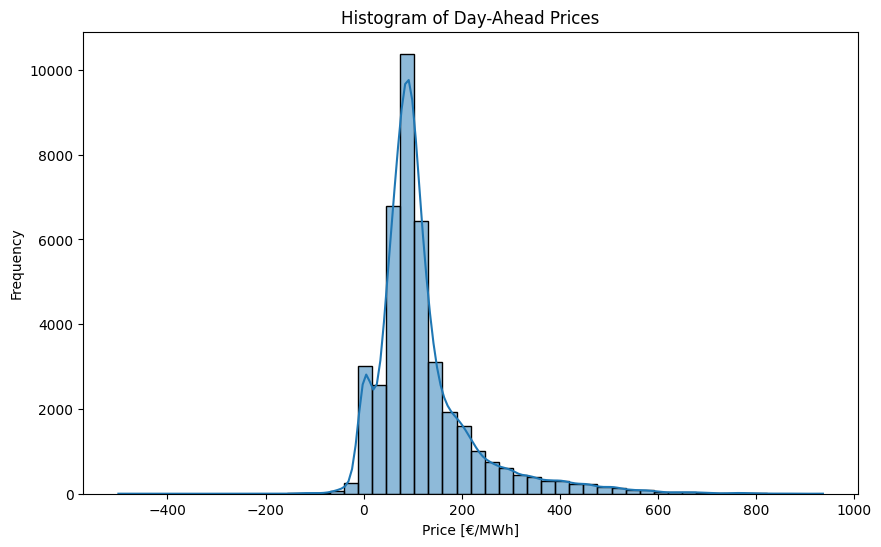

In [239]:
# Histogram of day-ahead prices
plt.figure(figsize=(10, 6))
sns.histplot(data=gen_and_prices_df, x='Germany/Luxembourg [€/MWh]', bins=50, kde=True)
plt.title('Histogram of Day-Ahead Prices')
plt.xlabel('Price [€/MWh]')
plt.ylabel('Frequency')
plt.show()

In [240]:
# Outlier analysis 
price_col = target_col
Q1 = gen_and_prices_df[price_col].quantile(0.25)
Q3 = gen_and_prices_df[price_col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = gen_and_prices_df[(gen_and_prices_df[price_col] < lower_bound) | 
                            (gen_and_prices_df[price_col] > upper_bound)]

print(f"Outliers: {len(outliers)} out of {len(gen_and_prices_df)} ({len(outliers)/len(gen_and_prices_df)*100:.1f}%)")
print(f"Negative prices: {(gen_and_prices_df[price_col] < 0).sum()} occurrences")

Outliers: 3786 out of 41119 (9.2%)
Negative prices: 1481 occurrences


#### Observations (Temporal Price Patterns)

- December and autumn months show higher median prices → seasonal demand + lower solar.
- Weekends + public holidays generally lower → reduced industrial/commercial load.
- Hourly pattern: intra-day variance persists (peaks around daytime vs night).

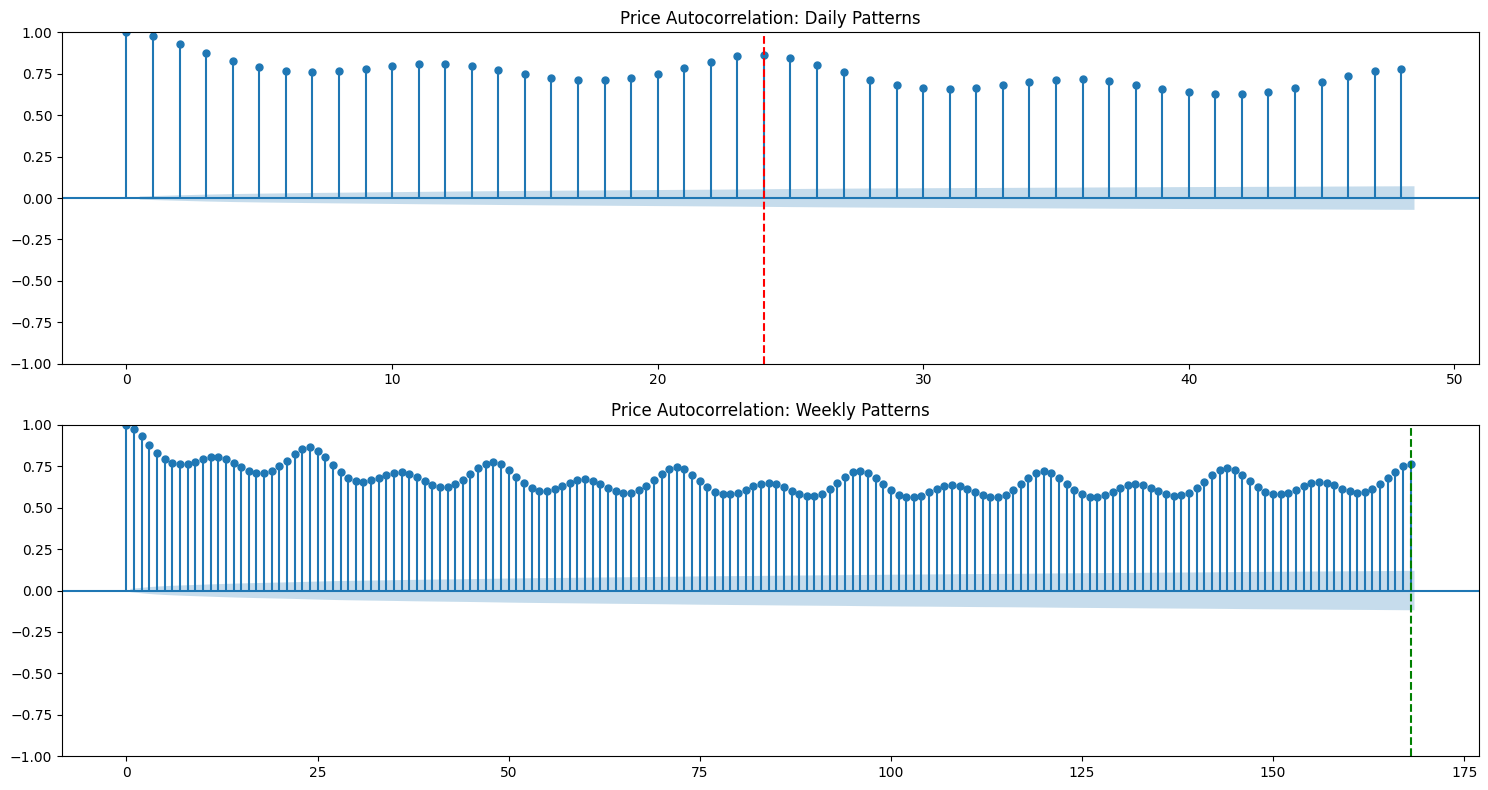

Validation of engineered lag features:
  24h lag: 0.864 correlation
  48h lag: 0.777 correlation
  168h lag: 0.764 correlation


In [241]:
# Get your price series
price_series = gen_and_prices_df[target_col]

# This does what we did manually, but for 168 different lags
autocorr_values = acf(price_series.dropna(), nlags=366*24, fft=True)

# Autocorrelation analysis to understand temporal patterns in German energy prices
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Plot 1: Daily patterns
plot_acf(price_series.dropna(), lags=48, ax=axes[0], title='Price Autocorrelation: Daily Patterns')
axes[0].axvline(x=24, color='red', linestyle='--', label='24h cycle')

# Plot 2: Weekly patterns  
plot_acf(price_series.dropna(), lags=168, ax=axes[1], title='Price Autocorrelation: Weekly Patterns')
axes[1].axvline(x=168, color='green', linestyle='--', label='Weekly cycle')

plt.tight_layout()
plt.show()

# Validate our feature engineering choices
strategic_lags = [24, 48, 168]
autocorr_values = acf(price_series.dropna(), nlags=200)

print("Validation of engineered lag features:")
for lag in strategic_lags:
    corr = autocorr_values[lag]
    print(f"  {lag}h lag: {corr:.3f} correlation")

### Observations (Univariate & Temporal Structure)
- Prices show clear seasonality (winter > summer) and daily cycles.
- Negative prices occur but form a small minority of hours (supply > demand windows).
- Strong price autocorrelation at 24h and 168h validates inclusion of daily and weekly lagged features.

### Result (What to Carry Forward)
- Retain engineered lag features: 24h, 48h, 168h, rolling 3-day averages, and previous-day std/spread.
- Include renewable ratio + its daily lag and short moving average for supply mix influence.
- Temporal categorical features (hour, day_of_week, month, season, holiday) are justified.
- Negative price handling: no special transformation yet; model can learn tail behavior.


## 7. Bivariate/Multivariate Analysis

### Correlation Analysis

#### An overview of correlations between different energy sources and day-ahead prices.

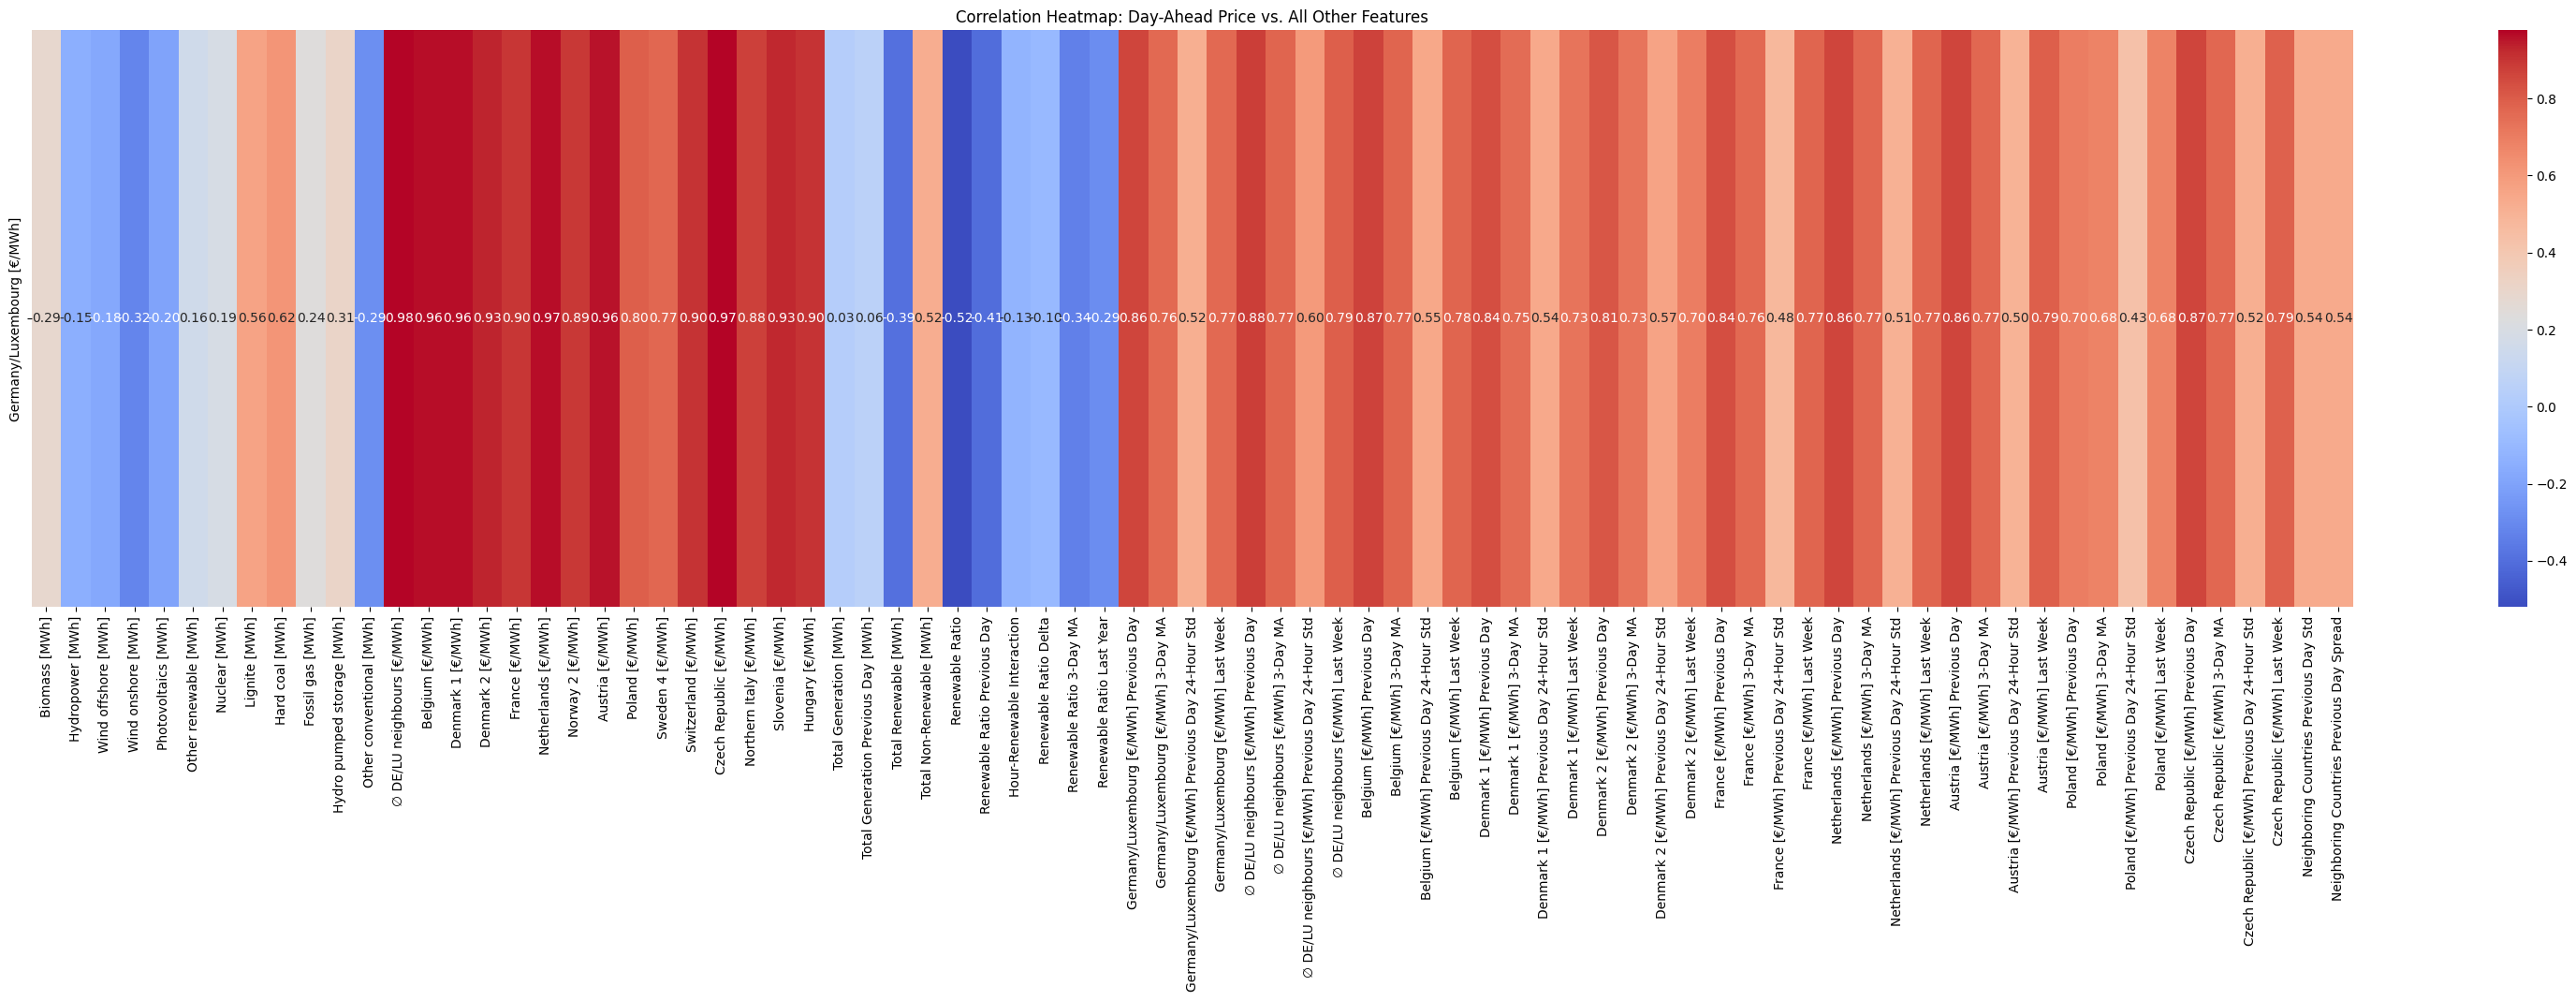

In [242]:
temporal_features_names = ['year', 'season', 'month', 'day_of_week', 'hour', 'public_holiday']

correlation_matrix =gen_and_prices_df.drop(columns=temporal_features_names).corr()[target_col].to_frame().T.drop(columns=target_col)
plt.figure(figsize=(40, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Day-Ahead Price vs. All Other Features')
plt.show()

#### Correlation between Day Ahead Prices and Previous Prices

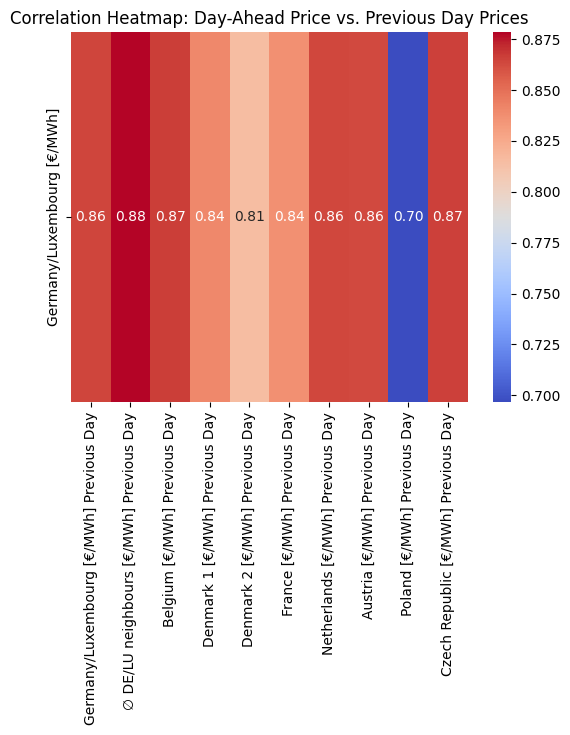

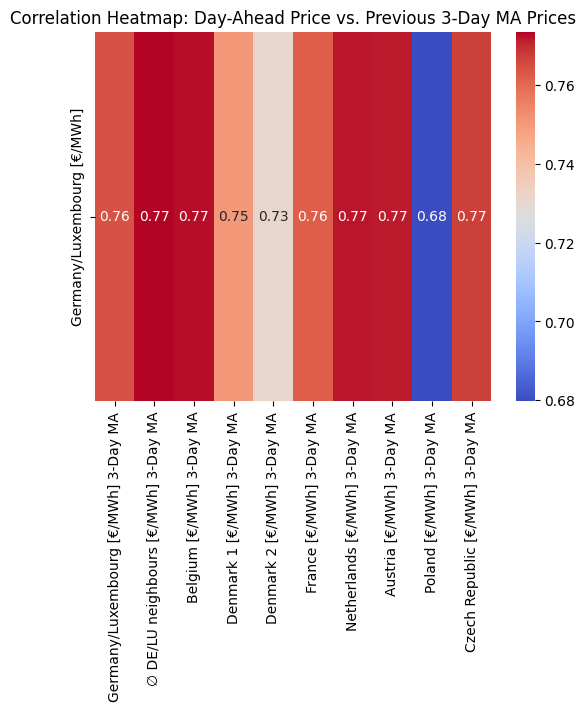

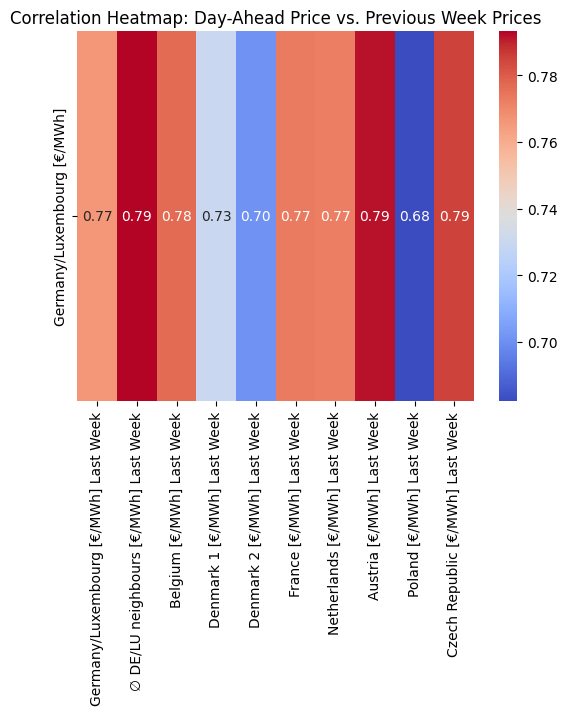

In [243]:
# Heatmap for correlation between Day-Ahead Prices and Previous Day Prices
sns.heatmap(correlation_matrix[previous_day_price_cols], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Day-Ahead Price vs. Previous Day Prices')
plt.show()

# Heatmap for correlation between Day-Ahead Prices and Previous 3-Day Moving Average Prices
sns.heatmap(correlation_matrix[previous_3_day_MA_price_cols], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Day-Ahead Price vs. Previous 3-Day MA Prices')
plt.show()

# Heatmap for correlation between Day-Ahead Prices and Previous Week Prices
sns.heatmap(correlation_matrix[previous_week_price_cols], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Day-Ahead Price vs. Previous Week Prices')
plt.show()


#### Correlation between Day-Ahead Prices and Generation Sources in previous days

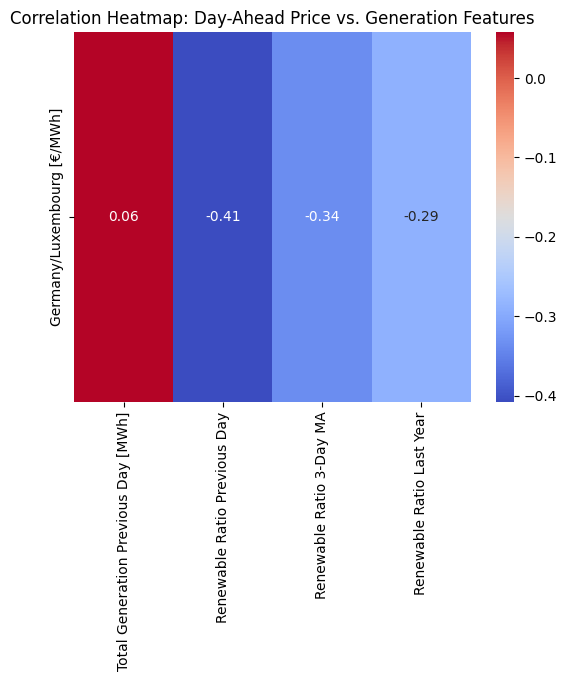

In [244]:
# Heatmap for correlation between Day-Ahead Prices and Generation Sources in previous day
sns.heatmap(correlation_matrix[['Total Generation Previous Day [MWh]', 'Renewable Ratio Previous Day', 'Renewable Ratio 3-Day MA', 'Renewable Ratio Last Year']], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Day-Ahead Price vs. Generation Features')
plt.show()

#### Observation:

- Renewable sources like wind and solar show moderate negative correlation with prices (~-0.40), suggesting higher renewable generation leads to lower prices.
- Neighboring countries' prices (FR, NL, BE) show the strongest positive correlation with Germany's prices, indicating interconnected markets.

#### Result (Feature Selection Signal)
- Prioritize lagged neighboring prices + spreads.
- Keep renewable ratio (and lag/MA) to capture supply pressure.
- Individual raw generation columns less predictive alone; ratio/aggregates better.

# 8. Insights and Observations

## Key Findings Summary
- Strongest predictors: neighboring country price lags + derived spread metrics (very high correlations ~0.9 range).
- Market integration effect outweighs domestic total generation correlation (weak direct link).
- Renewable supply share (ratio) shows a meaningful negative relationship (price dampening effect).
- Temporal structure: clear 24h + weekly cycles (supports daily/weekly lag features without excessive depth).
- Nuclear phase-out visible structurally post-April 2023; handled via zero-filled + no special adjustment needed yet.

## Implications for Modeling
- Focus feature space on: time lags (24/48/168), rolling stats, neighboring price structure, renewable ratio dynamics.
- Avoid overfitting with too many similar lag horizons beyond validated peaks.
- Consider future external features (load forecasts, weather proxies) in later sprints for uplift.


# 9. Next Steps / Conclusion

## Data Readiness
✅ Clean merged dataset with engineered temporal + lag features  
✅ Hourly datetime index (continuous sequence post-trim)  
✅ No major unresolved data quality gaps

## Modeling Strategy (Week 2 Start)
1. Target: Germany/Luxembourg day-ahead price (continuous regression)
2. Core Feature Buckets:
    - Lagged prices: 24h, 3-day MA, 24h rolling std, weekly same-hour
    - Neighbor market structure: 24h lag / 3-day MA / 24h STD / min/max
    - Renewable mix: 24h lag / 3-day MA / delta / hourly interaction
    - Temporal: hour of day, day of week, month, season, year, holiday

3. Safeguards: ensure all lagged features computed using past-only (already enforced by shift + dropna)

## Potential Enhancements (Future Sprints)
- Weather proxies (temperature, wind speed, solar irradiance) for improved renewable supply inference.
- Load forecast integration (if accessible) or synthetic demand proxies.
- Regime detection (cluster price patterns) → conditional modeling.

All set to proceed into the modeling phase.
